In [3]:
import numpy as np
from smt.surrogate_models import KRG, RBF
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import keras
from keras import layers
import keras_tuner


In [8]:
def read_data(type, folder, length):
    df = pd.DataFrame()
    parameters = pd.read_csv('Simulation_'+type+'/parameters_v1.txt')
    for i in range(length):
        new_data = pd.read_csv('Simulation_'+type+'/'+folder+'/'+type+'_X_data.csv/'+type+'_'+str(i+1)+'_data.csv')
        mean_force = new_data['FKN'].mean()
        max_force = new_data['FKN'].max()
        new_data_df = pd.DataFrame()
        new_data_df['mean_force'] = [mean_force]
        new_data_df['max_force'] = [max_force]
        for parameter in parameters.columns:
            new_data_df[parameter] = parameters[parameter][i]
        df = pd.concat([df, new_data_df])
    df = df.drop(columns=['sample'])
    df.reset_index(drop=True, inplace=True)

    return df

df = read_data(type='BENDING', folder='CONSTANT_THICKNESS_100', length=100)

In [9]:
X = df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
#Y = df[['max_force', 'mean_force']]
Y = df[['mean_force']].values

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [11]:
gamma_values = np.logspace(-4, 2, num=50)
C_values = np.logspace(-1, 4, num=50)
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']

In [16]:
values = []
for i in range(1000):
    gamma = np.random.choice(gamma_values)
    C = np.random.choice(C_values)
    kernel = np.random.choice(kernel_values)

    svr = SVR(kernel=kernel, C=C, gamma=gamma)
    svr.fit(X_train, Y_train)
    Y_pred = svr.predict(X_val)
    mse = mean_squared_error(Y_val, Y_pred)
    values.append([mse, gamma, C, kernel])

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

In [17]:
values = np.array(values)
print(values[:,0].argmin())
print(values[values[:,0].argmin()])

911
['0.045945619929505487' '0.15264179671752334' '372.7593720314942' 'rbf']


In [18]:
space = dict()
space['C'] = np.logspace(-1, 4, num=100)
space['epsilon'] = np.logspace(-3, 2, num=100)

In [23]:
search = RandomizedSearchCV(SVR(kernel='rbf', gamma=0.1), space, n_iter=1000, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, random_state=42)

In [24]:
result = search.fit(X_train, Y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

In [28]:
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -0.05624299321040466
Best Hyperparameters: {'epsilon': 0.052140082879996844, 'C': 42.29242874389499}


In [ ]:
SVR_model = SVR(kernel='rbf', C=100, gamma= 0.1)
SVR_model = SVR(kernel='rbf', epsilon=0.001, C=5.21)
SVR_model.fit(X_train,Y_train)

In [29]:
theta0_values = np.linspace(0.001, 1000, 10)
print(theta0_values)
results = {}
for i in range(len(theta0_values)):
    KRG_model = KRG(theta0=[theta0_values[i]], corr='squar_exp')
    KRG_model.set_training_values(X_train, Y_train)
    KRG_model.train()
    Y_pred = KRG_model.predict_values(X_val)
    mse = mean_squared_error(Y_val, Y_pred)
    results[theta0_values[i]] = mse

[1.00000e-03 1.11112e+02 2.22223e+02 3.33334e+02 4.44445e+02 5.55556e+02
 6.66667e+02 7.77778e+02 8.88889e+02 1.00000e+03]
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  2.0253723
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0061450
   
   Prediction time/pt. (sec) :  0.0003073
   
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
    

/opt/homebrew/lib/python3.11/site-packages/smt/surrogate_models/krg_based.py:1775: UserWarning: Warning: theta0 is out the feasible bounds. A random initialisation is used instead.
  warnings.warn(


   Training - done. Time (sec):  1.5205052
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0085890
   
   Prediction time/pt. (sec) :  0.0004295
   
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...


/opt/homebrew/lib/python3.11/site-packages/smt/surrogate_models/krg_based.py:1775: UserWarning: Warning: theta0 is out the feasible bounds. A random initialisation is used instead.
  warnings.warn(


   Training - done. Time (sec):  0.9840529
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0090089
   
   Prediction time/pt. (sec) :  0.0004504
   
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...


/opt/homebrew/lib/python3.11/site-packages/smt/surrogate_models/krg_based.py:1775: UserWarning: Warning: theta0 is out the feasible bounds. A random initialisation is used instead.
  warnings.warn(


   Training - done. Time (sec):  1.6061382
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0077000
   
   Prediction time/pt. (sec) :  0.0003850
   
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...


/opt/homebrew/lib/python3.11/site-packages/smt/surrogate_models/krg_based.py:1775: UserWarning: Warning: theta0 is out the feasible bounds. A random initialisation is used instead.
  warnings.warn(


   Training - done. Time (sec):  0.8765750
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0081658
   
   Prediction time/pt. (sec) :  0.0004083
   
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...


/opt/homebrew/lib/python3.11/site-packages/smt/surrogate_models/krg_based.py:1775: UserWarning: Warning: theta0 is out the feasible bounds. A random initialisation is used instead.
  warnings.warn(


   Training - done. Time (sec):  0.8004692
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0057342
   
   Prediction time/pt. (sec) :  0.0002867
   
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...


/opt/homebrew/lib/python3.11/site-packages/smt/surrogate_models/krg_based.py:1775: UserWarning: Warning: theta0 is out the feasible bounds. A random initialisation is used instead.
  warnings.warn(


   Training - done. Time (sec):  0.9512191
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0061679
   
   Prediction time/pt. (sec) :  0.0003084
   
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...


/opt/homebrew/lib/python3.11/site-packages/smt/surrogate_models/krg_based.py:1775: UserWarning: Warning: theta0 is out the feasible bounds. A random initialisation is used instead.
  warnings.warn(


   Training - done. Time (sec):  1.0388131
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0096767
   
   Prediction time/pt. (sec) :  0.0004838
   
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...


/opt/homebrew/lib/python3.11/site-packages/smt/surrogate_models/krg_based.py:1775: UserWarning: Warning: theta0 is out the feasible bounds. A random initialisation is used instead.
  warnings.warn(


   Training - done. Time (sec):  0.8360269
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0153599
   
   Prediction time/pt. (sec) :  0.0007680
   
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...


/opt/homebrew/lib/python3.11/site-packages/smt/surrogate_models/krg_based.py:1775: UserWarning: Warning: theta0 is out the feasible bounds. A random initialisation is used instead.
  warnings.warn(


   Training - done. Time (sec):  0.8588650
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0059907
   
   Prediction time/pt. (sec) :  0.0002995
   


{0.001: 0.1293620111717917, 111.11200000000001: 0.1403206142533776, 222.223: 0.1403206142533776, 333.334: 0.1403206142533776, 444.445: 0.1403206142533776, 555.556: 0.1403206142533776, 666.667: 0.1403206142533776, 777.778: 0.1403206142533776, 888.889: 0.1403206142533776, 1000.0: 0.1403206142533776}
0.001


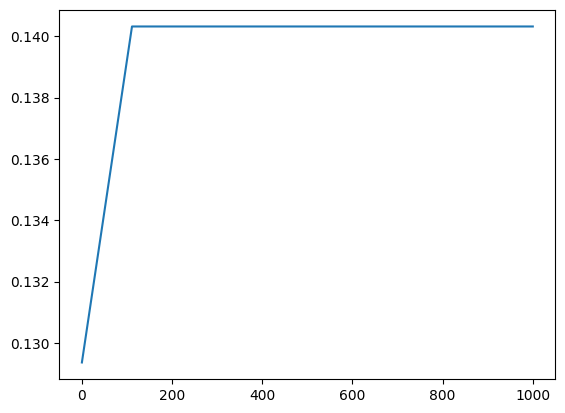

In [30]:
print(results)
plt.plot(results.keys(), results.values())
print(min(results, key=results.get))

In [12]:
KRG_model = KRG(theta0=[1e-2], corr='squar_exp')
KRG_model.set_training_values(X_train, Y_train)
KRG_model.train()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  1.6138051


In [13]:
d0_values = np.linspace(10, 1000, 100)
print(d0_values)
results_train = {}
results_val = {}
for i in range(len(d0_values)):
    RBF_model = RBF(d0=d0_values[i])
    RBF_model.set_training_values(X_train, Y_train)
    RBF_model.train()
    Y_pred_train = RBF_model.predict_values(X_train)
    Y_pred_val = RBF_model.predict_values(X_val)
    results_val[d0_values[i]] = mean_squared_error(Y_val, Y_pred_val)
    results_train[d0_values[i]] = mean_squared_error(Y_train, Y_pred_train)

[  10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.  120.
  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.  240.
  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.  360.
  370.  380.  390.  400.  410.  420.  430.  440.  450.  460.  470.  480.
  490.  500.  510.  520.  530.  540.  550.  560.  570.  580.  590.  600.
  610.  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.  720.
  730.  740.  750.  760.  770.  780.  790.  800.  810.  820.  830.  840.
  850.  860.  870.  880.  890.  900.  910.  920.  930.  940.  950.  960.
  970.  980.  990. 1000.]
___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing li

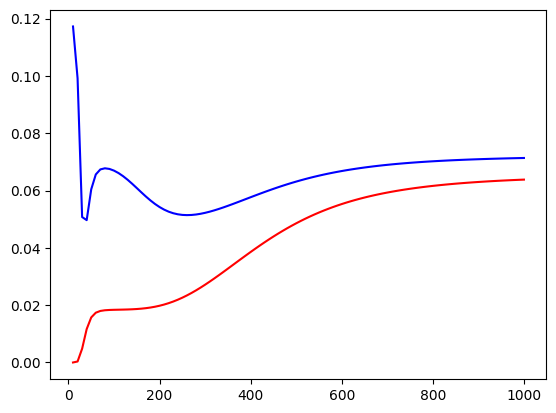

In [15]:
plt.plot(results_val.keys(), results_val.values(), color='blue')
plt.plot(results_train.keys(), results_train.values(), color='red')

In [ ]:
RBF_model = RBF(d0=min(results_val, key=results_val.get))
#RBF_model = RBF(d0=0.1)
RBF_model.set_training_values(X_train, Y_train)
RBF_model.train()
Y_pred = RBF_model.predict_values(X_val)

In [ ]:
#   1. Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

#   2. Compile the model
model.compile(optimizer='adam', loss='mse')

#   3. Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

#    4. Train the model
history = model.fit(
    X_train,
    Y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

In [ ]:
Y_predicted_KRG = KRG_model.predict_values(X_val)
Y_predicted_RBF = RBF_model.predict_values(X_val)
Y_predicted_SVR = SVR_model.predict(X_val)
Y_predicted_ANN = model.predict(X_val)

In [ ]:
mse_KRG = mean_squared_error(Y_val, Y_predicted_KRG)
mse_RBF = mean_squared_error(Y_val, Y_predicted_RBF)
mse_SVR = mean_squared_error(Y_val, Y_predicted_SVR)
mse_ANN = mean_squared_error(Y_val, Y_predicted_ANN)
print("MSE, for KRG:", mse_KRG)
print("MSE, for RBF:", mse_RBF)
print("MSE, for SVR:", mse_SVR)
print("MSE, for ANN:", mse_ANN)

In [ ]:
mae_KRG = mean_absolute_error(Y_val, Y_predicted_KRG)
mae_RBF = mean_absolute_error(Y_val, Y_predicted_RBF)
mae_SVR = mean_absolute_error(Y_val, Y_predicted_SVR)
mae_ANN = mean_absolute_error(Y_val, Y_predicted_ANN)
print("MAE, for KRG:", mae_KRG)
print("MAE, for RBF:", mae_RBF)
print("MAE, for SVR:", mae_SVR)
print("MAE, for ANN:", mae_ANN)

In [ ]:
mape_KRG = mean_absolute_percentage_error(Y_val, Y_predicted_KRG)
mape_RBF = mean_absolute_percentage_error(Y_val, Y_predicted_RBF)
mape_SVR = mean_absolute_percentage_error(Y_val, Y_predicted_SVR)
mape_ANN = mean_absolute_percentage_error(Y_val, Y_predicted_ANN)
print("MAPE, for KRG:", format(round(mape_KRG, 4)*100,'.2f'), "%")
print("MAPE, for RBF:", format(round(mape_RBF, 4)*100,'.2f'), "%")
print("MAPE, for SVR:", format(round(mape_SVR, 4)*100,'.2f'), "%")
print("MAPE, for ANN:", format(round(mape_ANN, 4)*100,'.2f'), "%")

In [ ]:
plt.bar(['KRG', 'RBF', 'SVR', 'ANN'], [mse_KRG, mse_RBF, mse_SVR, mse_ANN])
plt.bar(['KRG', 'RBF', 'SVR', 'ANN'], [mae_KRG, mae_RBF, mae_SVR, mae_ANN])
plt.show()

In [ ]:
plt.plot([23,28], [23, 28], label='y=x', color='gray')

plt.scatter(Y_val,Y_predicted_SVR, s=5, label= 'SVR', color='red')
plt.scatter(Y_val, Y_predicted_KRG, s=5, label='KRG', color='green')
plt.scatter(Y_val, Y_predicted_ANN, s=5, label='ANN', color='orange')
plt.scatter(Y_val, Y_predicted_RBF, s=5, label='RBF', color='blue')

plt.xlabel('True force [kN]')
plt.ylabel('Predicted force [kN]')
plt.legend()